In [2]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

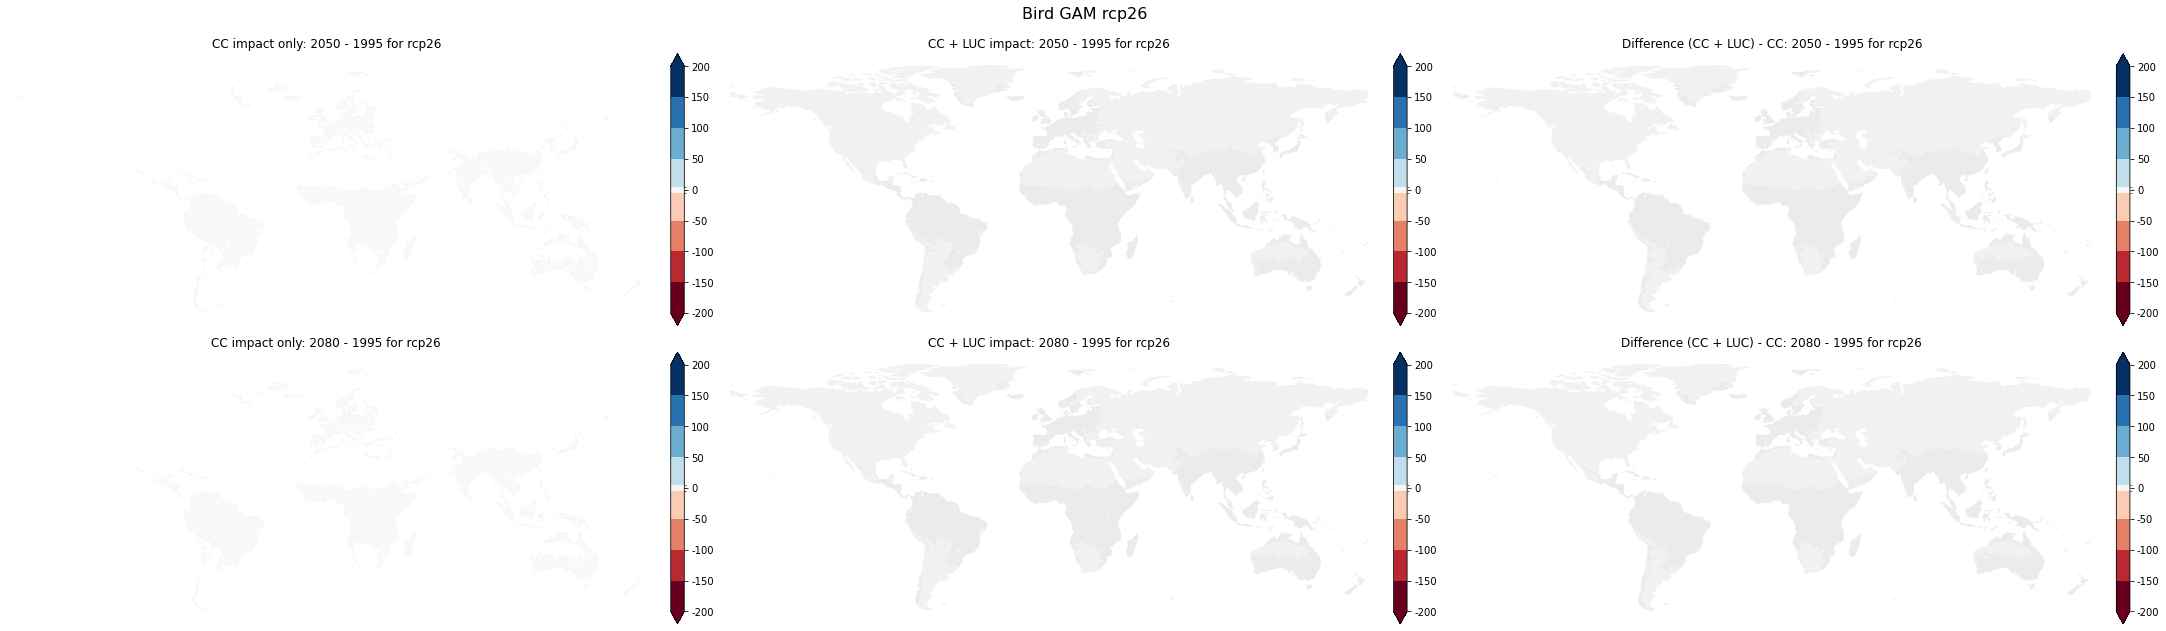

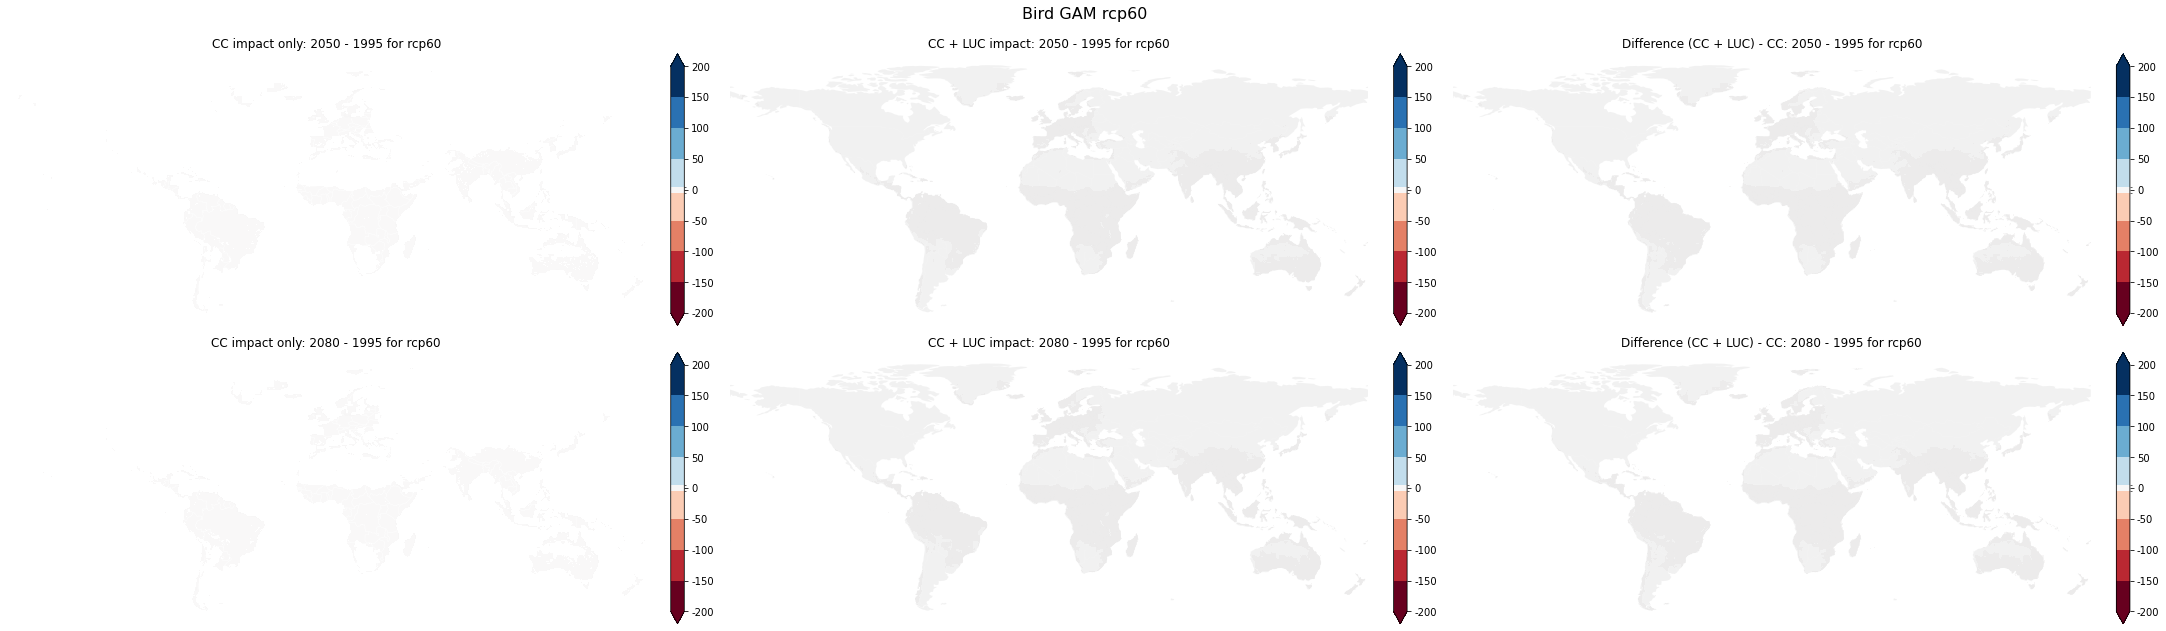

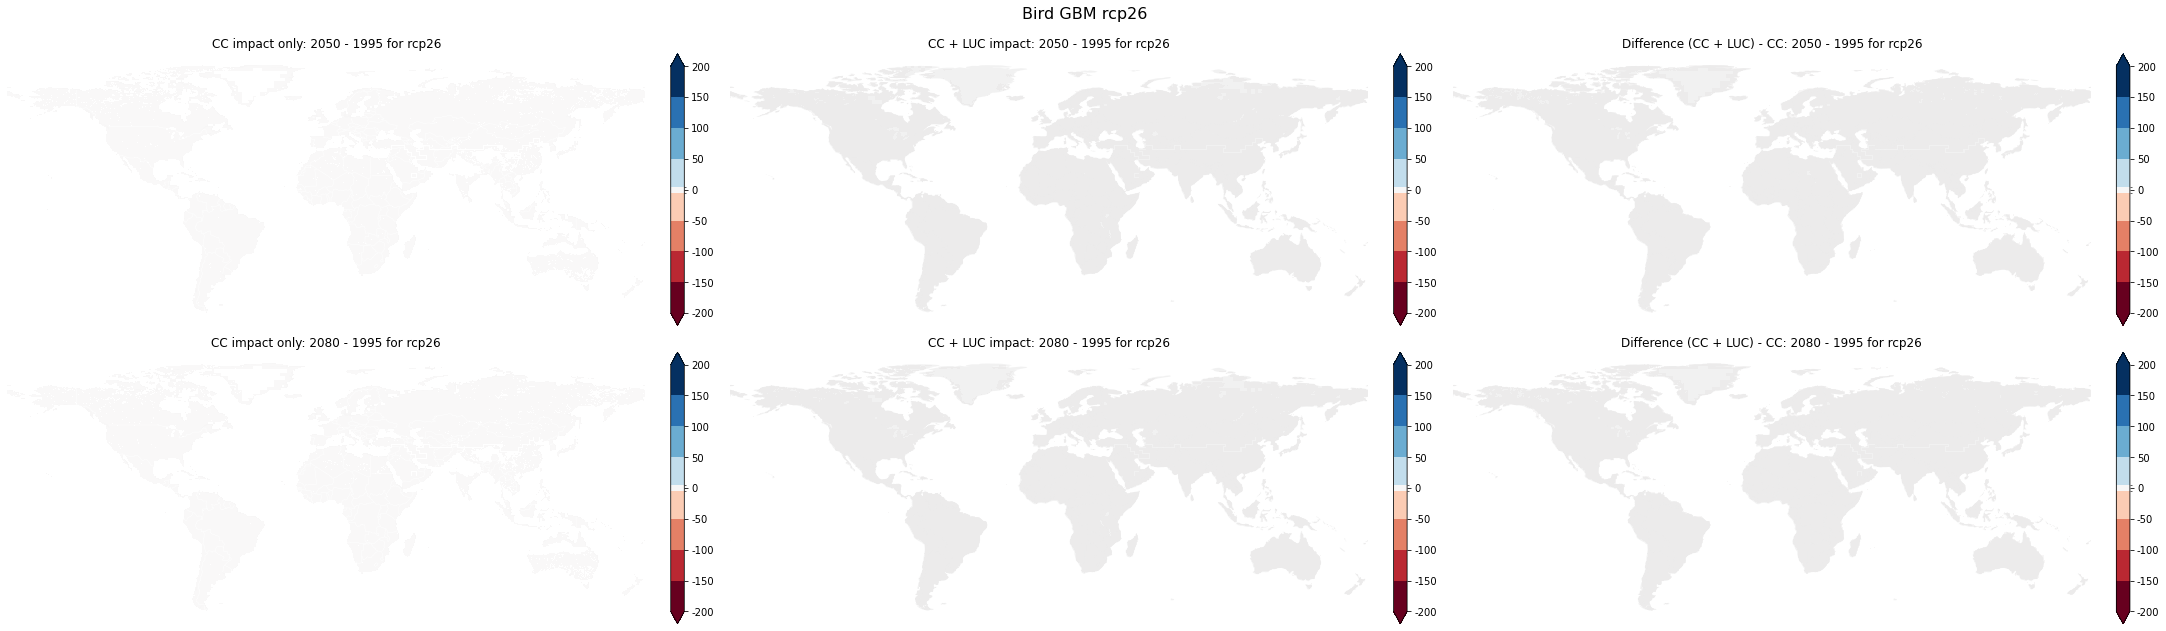

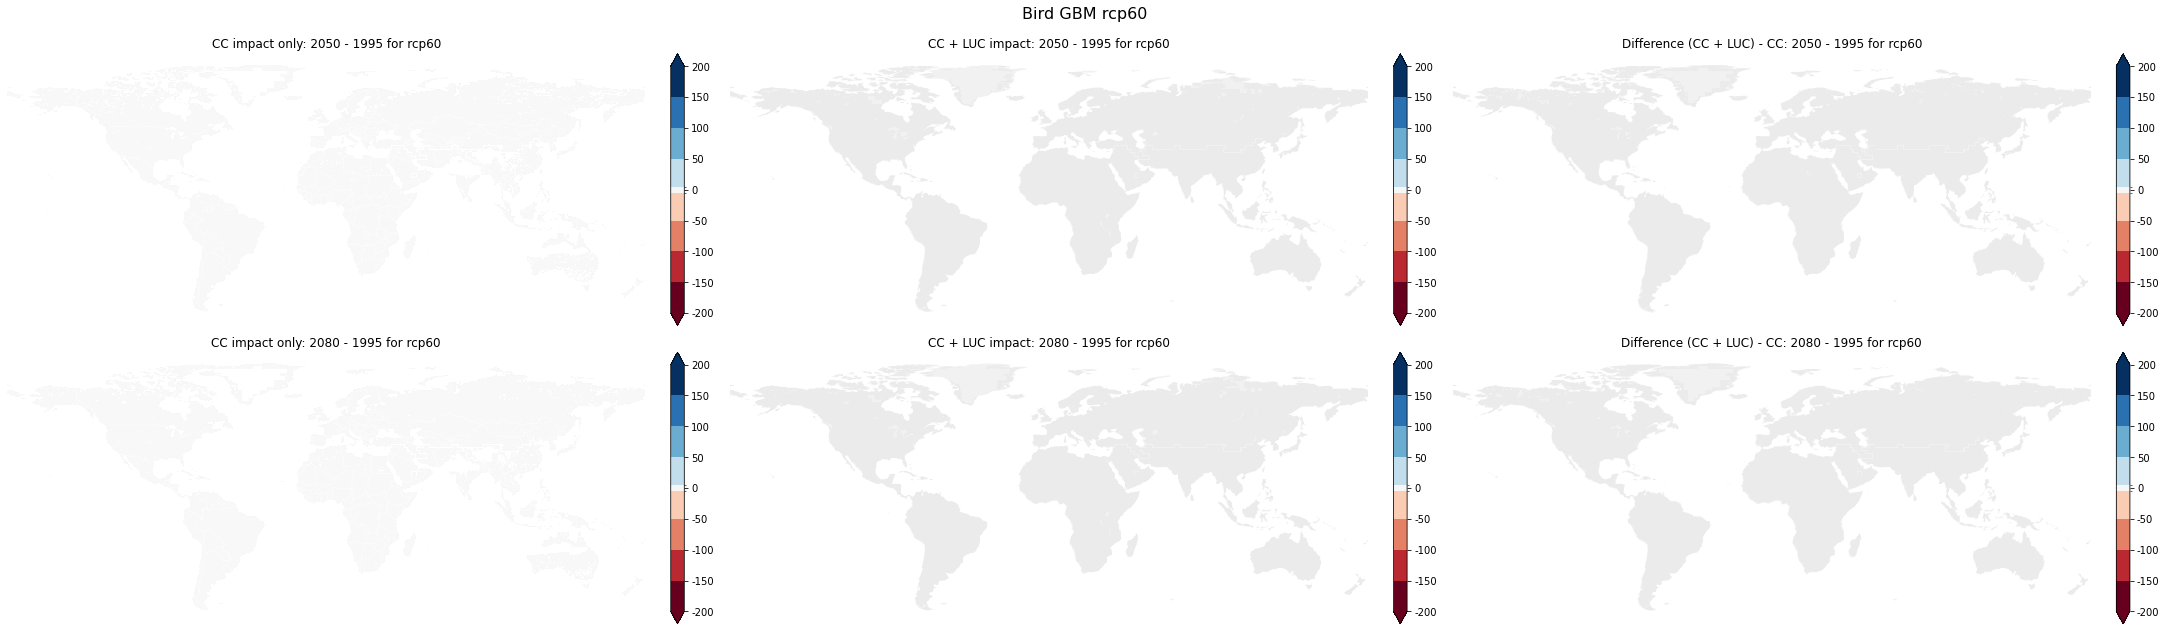

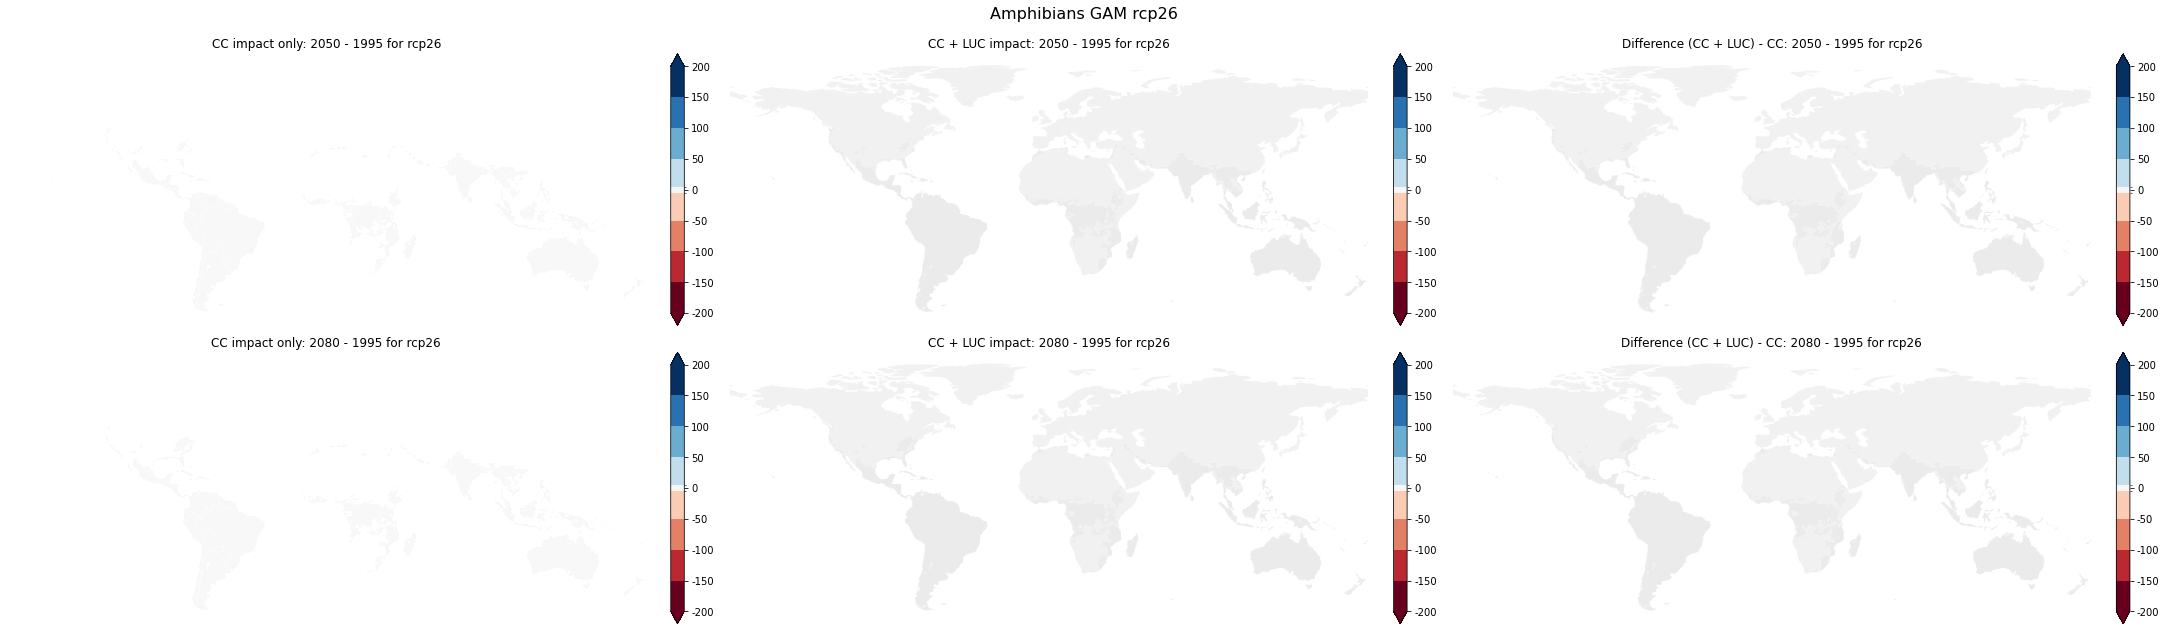

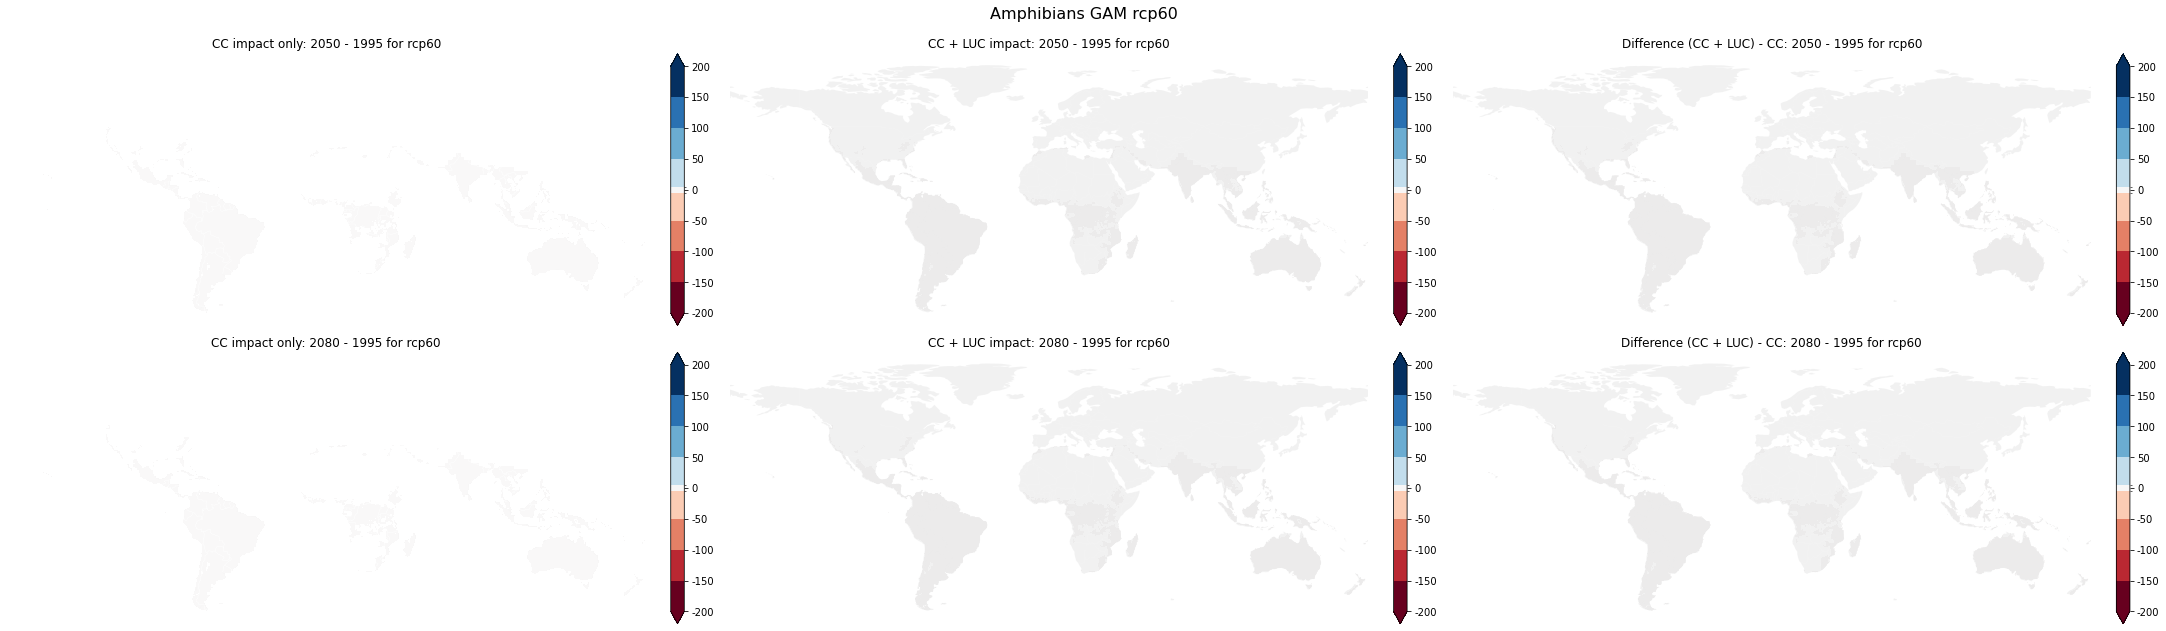

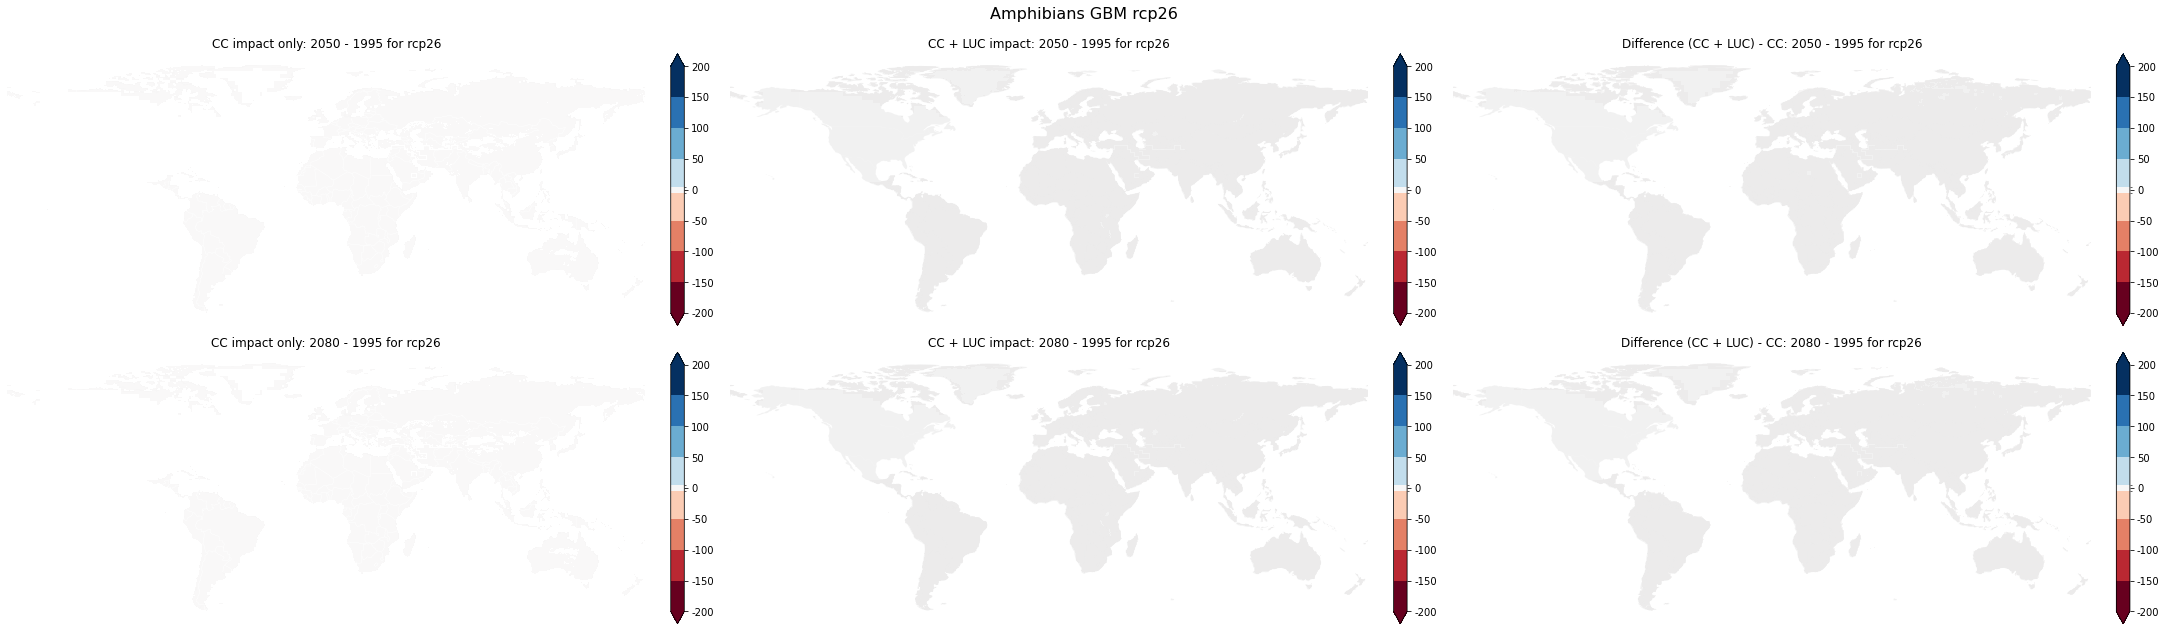

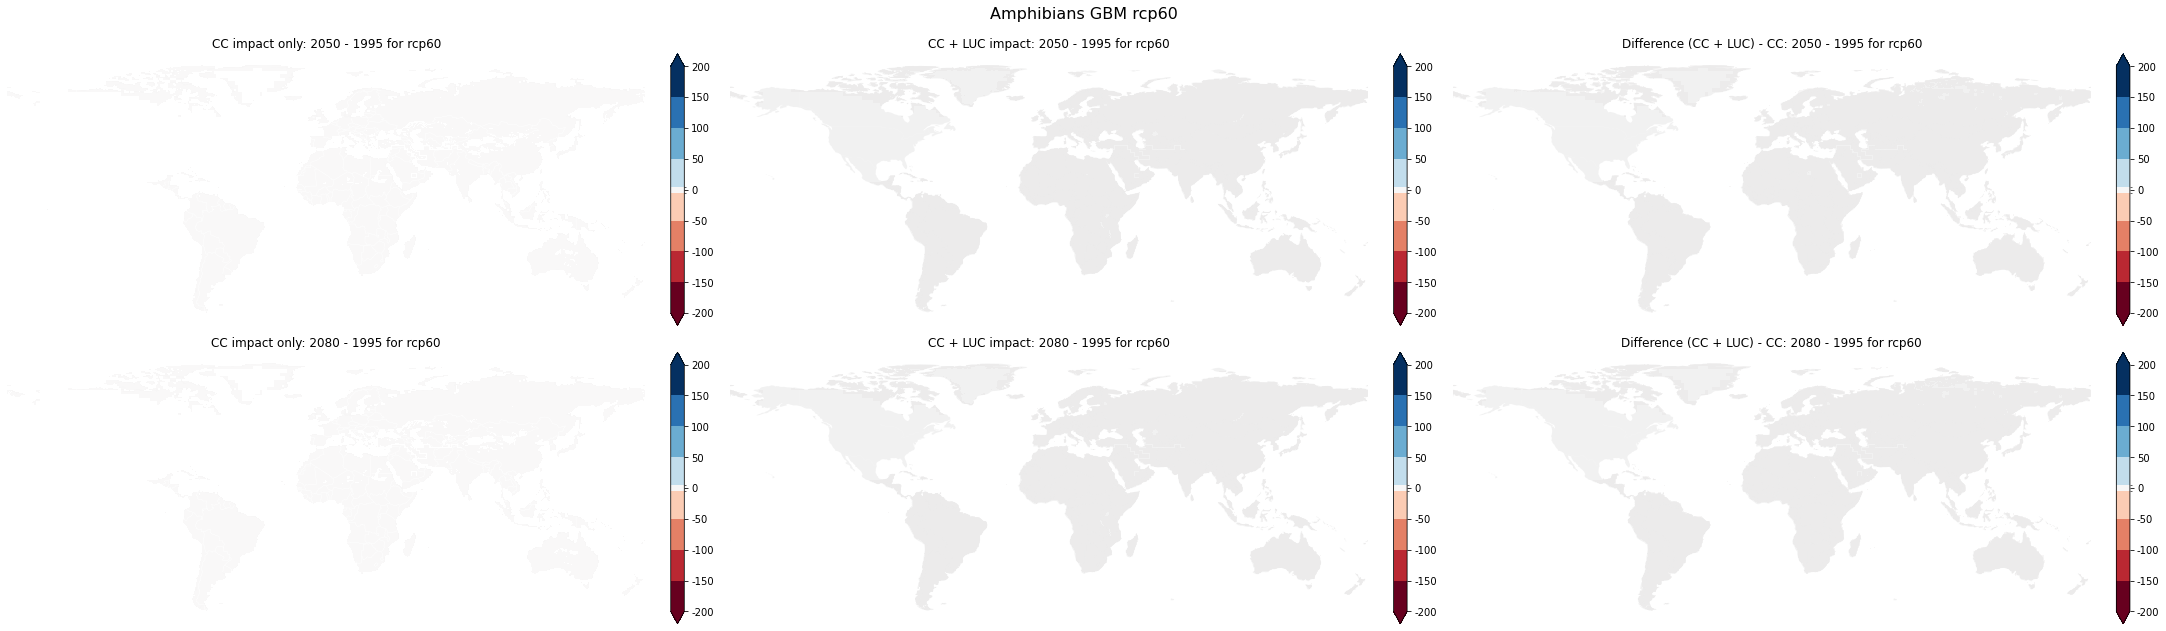

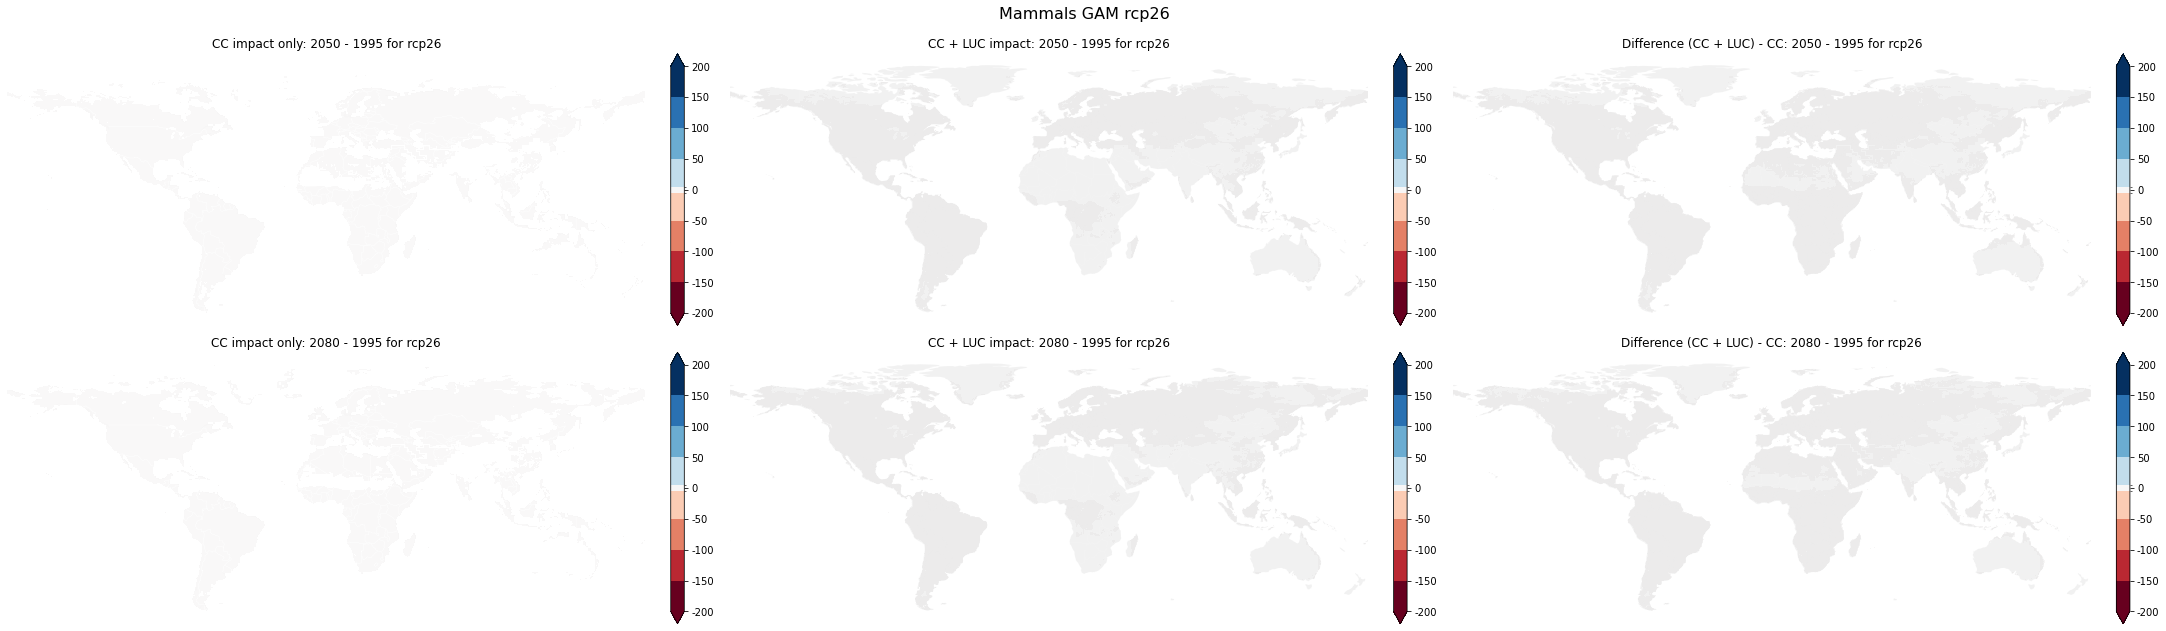

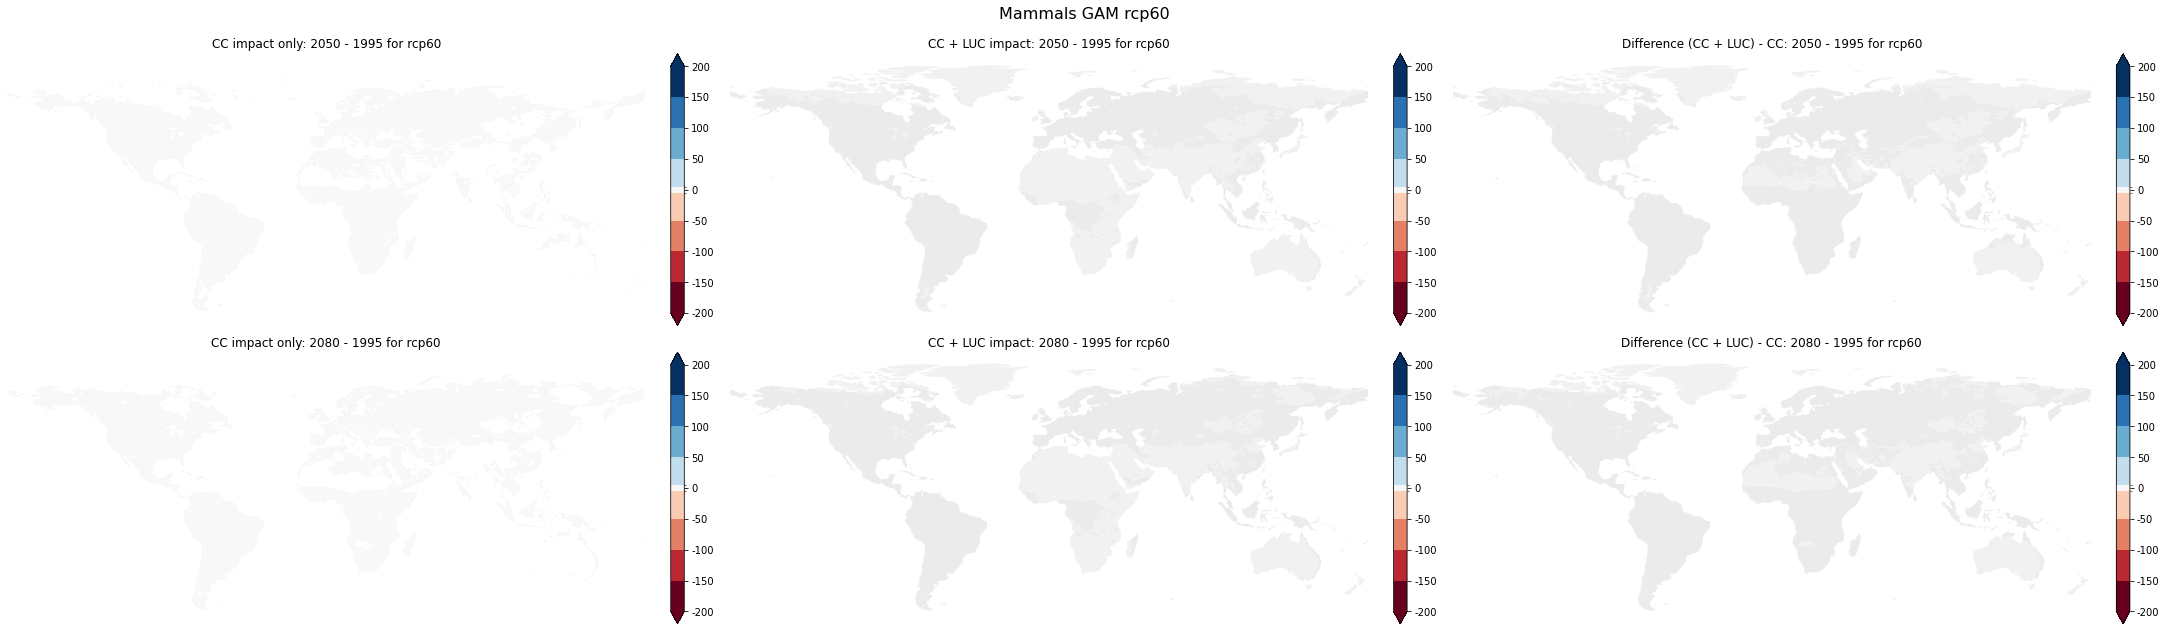

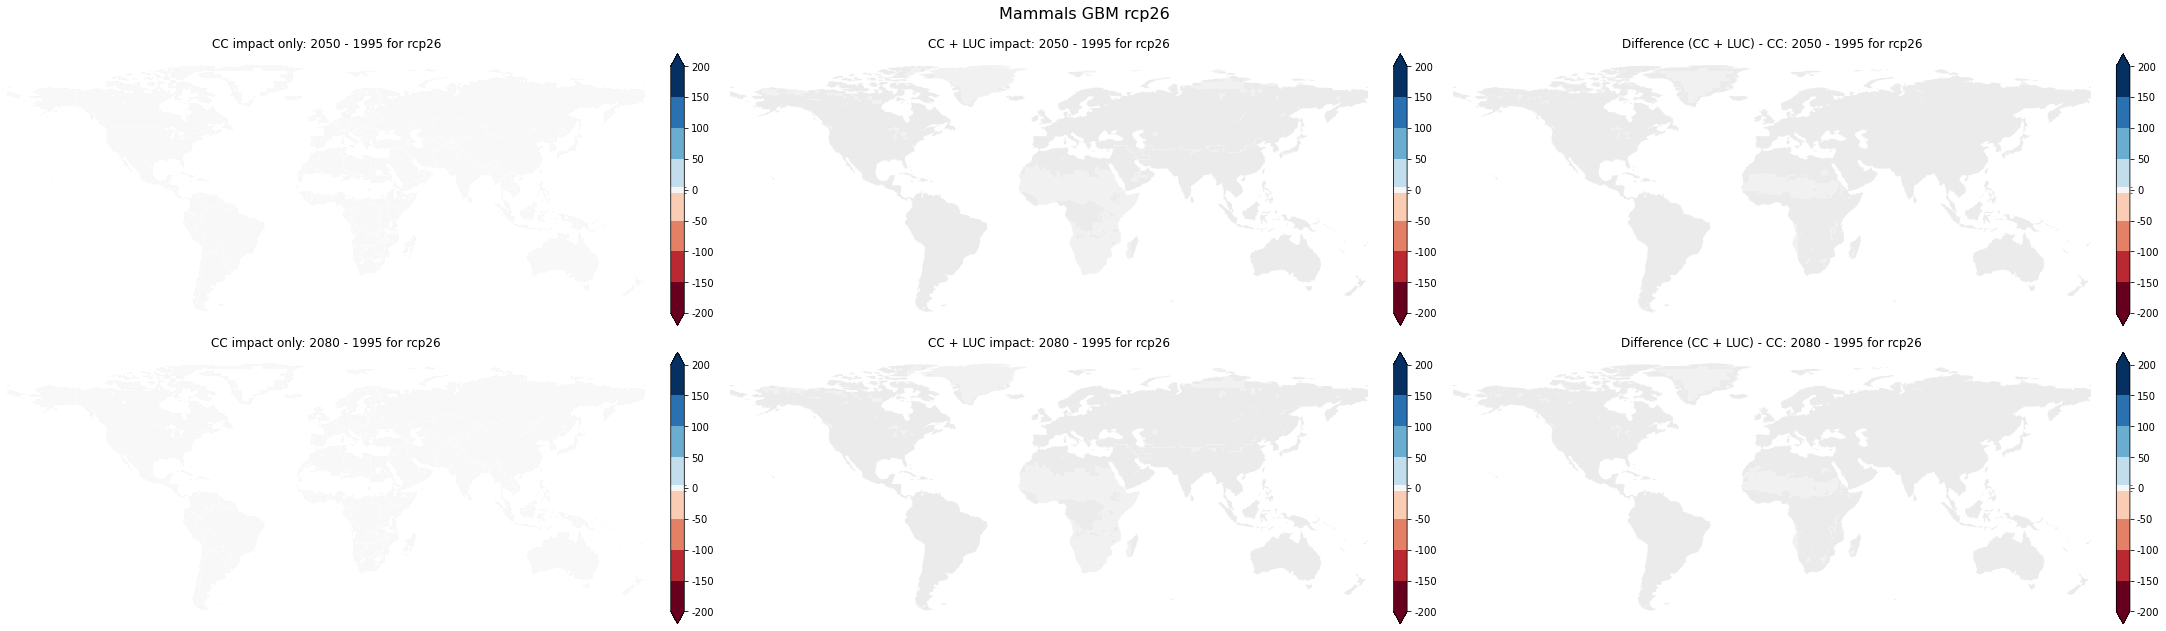

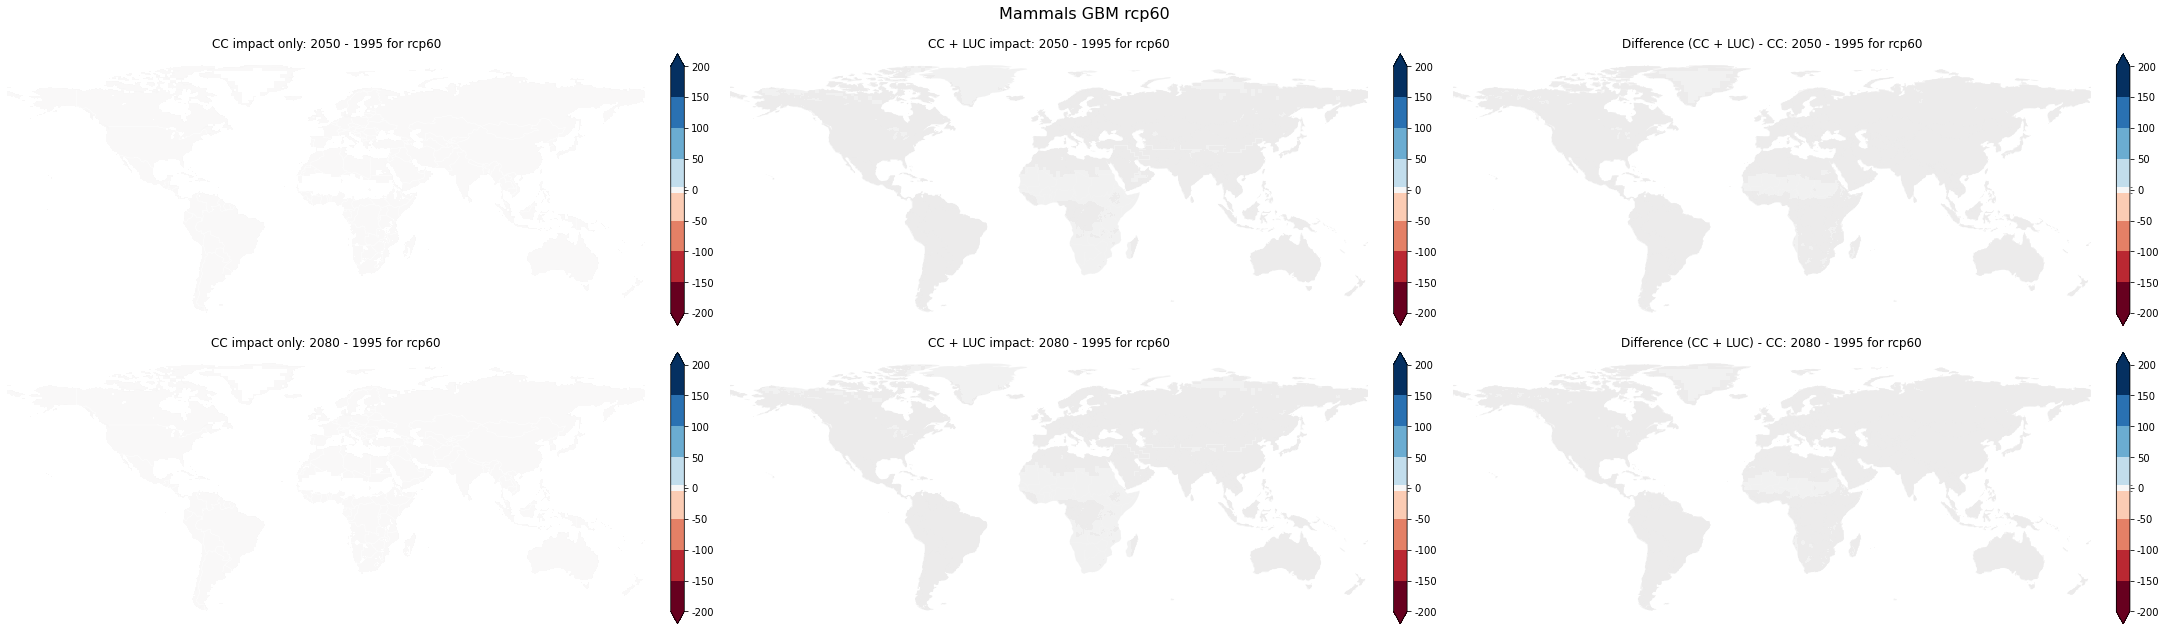

In [7]:
### SDM MODEL SDMs separately  ##### 

warnings.filterwarnings('ignore', category=UserWarning)

models = ["GAM","GBM"]
taxas = ["Bird","Amphibians","Mammals"]
scenarios = ["rcp26","rcp60"]


countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))
habitat="forest"
#newvalue
for taxa in taxas:
    for model in models:
        for scenario in scenarios:
            historical_time = 1146
            future_times = [35, 65]
            model_names = [ 'GFDL-ESM2M','IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
            netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

            fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")


            plot_idx = 0
            year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
            for future_time in future_times:


                newvalue_hist =f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"

                sumbin_hist =f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc"


                mean_value_bin_hist = xr.open_dataset(newvalue_hist,decode_times=False).to_array()
                mean_sum_bin_hist = xr.open_dataset(sumbin_hist,decode_times=False).to_array()
                #mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                #mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)

                newvalue_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"

                sumbin_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                mean_value_bin_future = xr.open_dataset(newvalue_fut,decode_times=False).to_array()
                mean_sum_bin_future = xr.open_dataset(sumbin_fut,decode_times=False).to_array()
                mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                # Calculate the differences
                diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                diff = diff_sum_bin - diff_value_bin

                diff_value_bin_ensemble = diff_value_bin.isel(variable=0)
                diff_sum_bin_ensemble = diff_sum_bin.isel(variable=0)
                diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble

                # Create three subplots for each future time and scenario
                if plot_idx >= len(axes.flatten()):
                    break
                ax1 = axes.flatten()[plot_idx]
                ax2 = axes.flatten()[plot_idx + 1]
                ax3 = axes.flatten()[plot_idx + 2]

                labels = ['a', 'b', 'c']
                # Define the colormap and the range of values for the colorbar
                vmin_b = diff_sum_bin.min().values
                vmax_b = diff_sum_bin.max().values

                cmap = plt.colormaps['RdBu']
                boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
                norm = BoundaryNorm(boundaries, cmap.N)

                # Plot the ensemble mean difference for each panel
                im1 = ax1.pcolormesh(diff_value_bin_ensemble['lon'].values, diff_value_bin_ensemble['lat'].values, np.where(diff_value_bin_ensemble.values != 0, diff_value_bin_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
                ax1.set_title(f"CC impact only: {year_indices[future_time]} - 1995 for {scenario}",loc='center')


                ax1.axis('off')
                ax1.set_extent((-180,180,-63,90))
                ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

                ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                tick_labels = [str(int(tick)) for tick in ticks_b]

                cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
                cbar1.set_ticklabels(tick_labels)



                im2 = ax2.pcolormesh(diff_sum_bin_ensemble['lon'].values, diff_sum_bin_ensemble['lat'].values,  np.where(diff_sum_bin_ensemble.values != 0, diff_sum_bin_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)

                ax2.set_title(f"CC + LUC impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

                ax2.axis('off')
                ax2.set_extent((-180,180,-63,90))
                cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
                cbar2.set_ticklabels(tick_labels)


                # ------------------------------------------------
                # Panel c 


                boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
                norm = BoundaryNorm(boundaries, cmap.N)
                cmap = plt.colormaps['RdBu']

                im3 = ax3.pcolormesh(diff_ensemble['lon'].values, diff_ensemble['lat'].values,  np.where(diff_ensemble.values != 0, diff_ensemble.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

                countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                ax3.set_title(f"Difference (CC + LUC) - CC: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

                ax3.axis('off')
                ax3.set_extent((-180,180,-63,90))

                ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
                tick_labels = [str(int(tick)) for tick in ticks_b]

                cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend='both')
                cbar3.set_ticklabels(tick_labels)
                # Increase the plot index by 3 to move to the next triplet of subplots
                plot_idx += 3


            plt.suptitle(taxa +" "+ model + " " + scenario , size=16, y=0.8)
            #plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/plots/species_richness_lu_binary_" + taxa + "_" + model + "_" + scenario)
            #plt.show() 
